In [1]:
# Importing necessary libraries
from matplotlib import legend
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
import numpy as np
from icecream import ic
from tqdm import tqdm
from itertools import chain
import logging
import os
import cProfile
import pstats
from dataloader import *
from get_data import *
from torch.utils.data import Dataset, DataLoader

In [29]:
visualise(get_data(path = "save_data_test3.csv", timesteps_from_data=0, skip_steps_start = 0, skip_steps_end = 0, 
                   drop_half_timesteps = False, normalise_s_w=False, rescale_p=False, num_inits=100), num_inits=10, set_ylim=True)

In [27]:
ws=50
n = 5
%matplotlib qt

data = get_data(path = "save_data_test3.csv", timesteps_from_data=0, skip_steps_start = 0, skip_steps_end = 400, drop_half_timesteps = True, normalise_s_w=False, rescale_p=False, num_inits=n)
data_set = CustomDataset(data, window_size=ws)
dataloader = DataLoader(data_set, batch_size=1)

time = np.linspace(0,data.size(dim=1)*n,data.size(dim=1)*n)

for i, (inp, label) in enumerate(dataloader):
    if i%2==0:
     plt.plot(time[i:i+ws], inp[0,:,0].numpy(), linewidth=5, alpha=0.2, color="red")
     #plt.scatter(time[i:i+ws], label[0,:,0].numpy(), linewidth=5, alpha=0.3, color="red")
     
    else:
     plt.plot(time[i:i+ws], inp[0,:,0].numpy(), linewidth=5, alpha=0.2, color="blue")

plt.grid()
plt.show()



In [4]:
inp.size()

torch.Size([1, 4, 3])

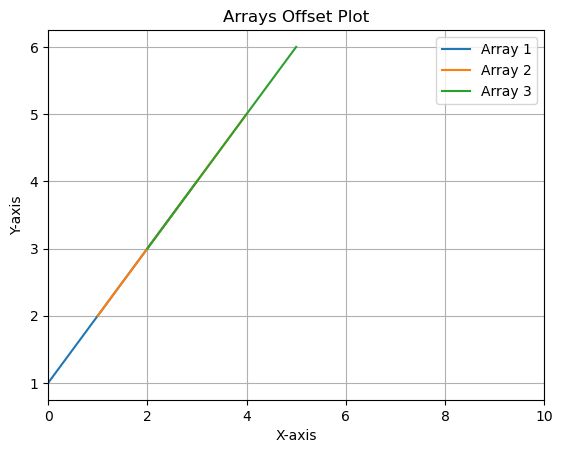

In [5]:


import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = np.arange(10)  # Extend the range of x-values
y1 = np.array([1, 2, 3, 4])
y2 = np.array([2, 3, 4, 5])
y3 = np.array([3, 4, 5, 6])

# Plot each array with offset
plt.plot(x[:4], y1, label='Array 1')
plt.plot(x[1:5], y2, label='Array 2')
plt.plot(x[2:6], y3, label='Array 3')
plt.xlim(0,10)
# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Arrays Offset Plot')
plt.legend()

# Show plot
plt.grid(True)
plt.show()